In [1]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf
from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.edgetpu import make_interpreter
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# Load TFLite model and allocate tensors.
model_name = "yolov5.tflite"
interpreter = make_interpreter(model_name, device=':0')
interpreter.allocate_tensors()



In [3]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

classes = [ 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' ]

In [4]:
input_shape = input_details[0]['shape']
input_shape

array([  1, 320, 320,   3], dtype=int32)

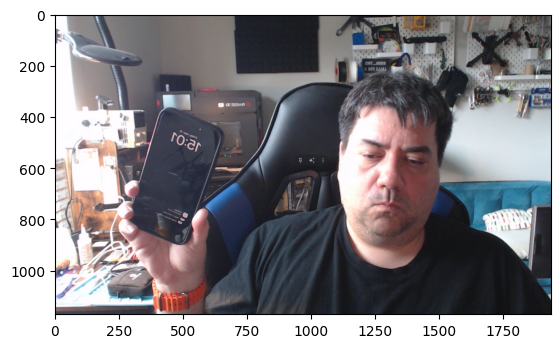

In [5]:
# img = Image.open('table.jpg')
img = Image.open('room2.png')

# max_dim = max(img.width, img.height)
# padded = Image.new(img.mode, (max_dim,max_dim), 'black')
# padded.paste(img,(0,0))
# img=padded
data = np.array(img.resize(input_shape[1:3],Image.Resampling.LANCZOS), dtype=np.float32)
data /= 255.0
data = data[np.newaxis,...]
plt.imshow(img)

In [15]:
common.set_input(interpreter, data[...,:3])
interpreter.invoke()
result = interpreter.get_tensor(output_details[0]['index']).squeeze(0)

In [16]:
# result = interpreter.get_tensor(output_details[0]['index']).squeeze(0)
boxes = result[...,0:4]
boxes[...,0]*= img.width
boxes[...,1]*= img.height
boxes[...,2]*= img.width
boxes[...,3]*= img.height
scores = result[...,4:5].squeeze()

In [17]:
scores

array([6.0781837e-04, 1.0655771e-04, 2.6295895e-05, ..., 6.9930786e-05,
       3.9874289e-05, 2.2283222e-05], dtype=float32)

In [18]:
selected = tf.image.non_max_suppression(
    boxes,
    scores,
    100,
    iou_threshold=0.2,
    score_threshold=0.3
)

In [19]:
for ix in selected:
    res = result[ix,:]
    xywh = boxes[ix,:4]
    conf = res[5:]*res[4:5]
    clas = np.argmax(conf)
    print(xywh, conf[clas], clas, classes[clas])

[1215.0377  691.891  1444.9907  944.2966] 0.8350252 0 person
[477.39575 626.793   368.9611  531.93335] 0.25432682 67 cell phone


[1215.0377  691.891  1444.9907  944.2966] 0.8350252 0 person
[477.39575 626.793   368.9611  531.93335] 0.25432682 67 cell phone


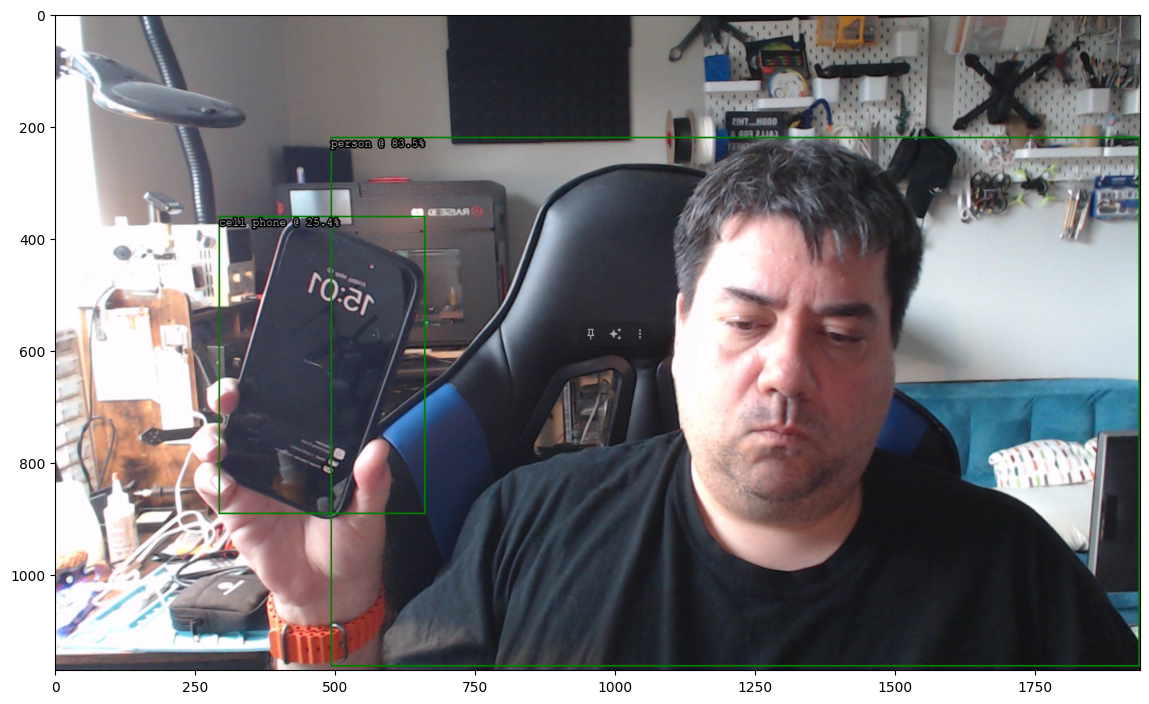

In [20]:
draw_img = img.copy()
drawing = ImageDraw.Draw(draw_img)
f = ImageFont.truetype('Courier New.ttf',20)

for ix in selected:
    res = result[ix,:]
    xywh = boxes[ix,:4]
    conf = res[5:]*res[4:5]
    clas = np.argmax(conf)
    print(xywh, conf[clas], clas, classes[clas])
 
    drawing.rectangle([xywh[0]-xywh[2]/2,xywh[1]-xywh[3]/2, xywh[0]+xywh[2]/2, xywh[1]+xywh[3]/2],
                      outline='green',width=3)
    drawing.text([xywh[0]-xywh[2]/2,xywh[1]-xywh[3]/2],fill='white', 
                 stroke_width=3, stroke_fill='black',font=f,  text=f'{classes[clas]} @ {conf[clas]*100:.1f}%')
plt.figure(figsize=(14,10))
plt.imshow(draw_img)